In [1]:

import warnings
warnings.filterwarnings('ignore')

import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração do estilo dos gráficos para uma melhor visualização
sns.set_theme(style="whitegrid")

# PySpark and Utils
try:
    sys.path.append(str(Path.cwd().parent / "src"))
    from pyspark.sql.functions import *
    import pyspark.sql.functions as F
    from pyspark.sql.types import *
    from pyspark.sql.window import Window
    from utils import create_spark_session, load_json_data, display_data_info_spark
except ImportError as e:
    print(f"Import PySpark Error : {e}")    
    raise


In [2]:
# Criando Spark
spark = create_spark_session()

# Configuração de paths
project_root = Path.cwd().parent
data_raw_path = project_root / "data" / "raw"
data_processed_path = project_root / "data" / "processed"

print(f"project_root: {project_root}")
print(f"data_raw_path: {data_raw_path}")
print(f"data_processed_path: {data_processed_path}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/13 08:51:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/08/13 08:51:13 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/08/13 08:51:13 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


project_root: /Users/viniciusromano/vinicius/ifood-case
data_raw_path: /Users/viniciusromano/vinicius/ifood-case/data/raw
data_processed_path: /Users/viniciusromano/vinicius/ifood-case/data/processed


In [3]:
offers_df = spark.read.parquet(f"{data_processed_path}/offers_processed.parquet")

offers_df.show(10, truncate=False)
offers_df.describe().show()
offers_df.printSchema()

25/08/13 08:51:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------------------+--------------------------------+---------------------+------+-----------+----+-----------------+--------+--------+--------+-----------------------+--------------+--------+---------+-------------------+---------------+------------------------+-----------+-------------+--------------+--------------+---------------------------+--------------------+----------------------+-----------------------+------------------------------------+-------------------------------+--------------------------+------------------------+-------------------+----------------------+-----------------+-----------------+---------------------+
|offer_id                        |profile_id                      |time_since_test_start|amount|funnel_step|age |credit_card_limit|gender_F|gender_M|gender_O|days_since_registration|discount_value|duration|min_value|offer_type_discount|offer_type_bogo|offer_type_informational|channel_web|channel_email|channel_mobile|channel_social|offer_generated

+-------+--------------------+--------------------+---------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-----------------------+------------------+------------------+-----------------+-------------------+-------------------+------------------------+------------------+--------------------+-------------------+-------------------+---------------------------+--------------------+----------------------+-----------------------+------------------------------------+-------------------------------+--------------------------+------------------------+-------------------+----------------------+------------------+-----------------+---------------------+
|summary|            offer_id|          profile_id|time_since_test_start|            amount|       funnel_step|               age| credit_card_limit|          gender_F|          gender_M|            gender_O|days_since_registration|    discount_va

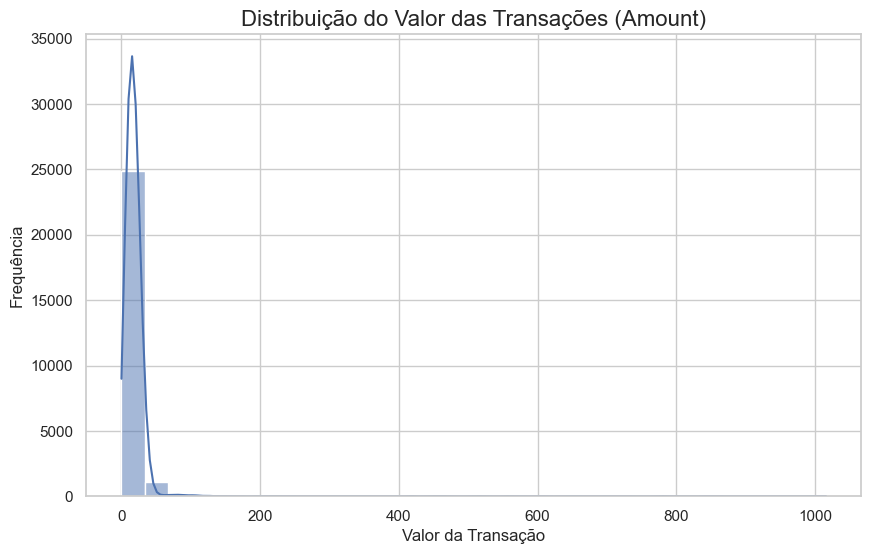

In [4]:
amount_pd = offers_df.select('amount').dropna().toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(data=amount_pd, x='amount', kde=True, bins=30)

plt.title('Distribuição do Valor das Transações (Amount)', fontsize=16)
plt.xlabel('Valor da Transação', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.show()

Grande parte das transações com valores bem baixos (com poucos outliers)

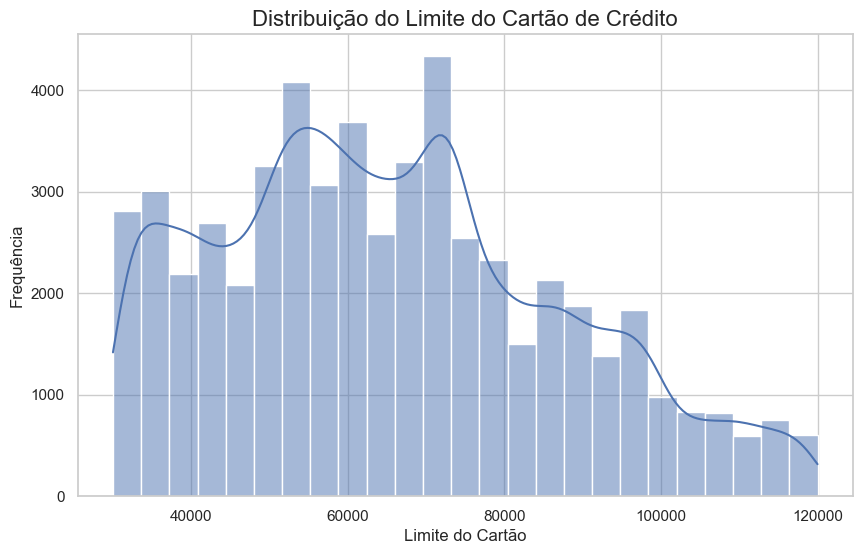

In [5]:
credit_limit_pd = offers_df.select('credit_card_limit').dropna().toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(data=credit_limit_pd, x='credit_card_limit', kde=True, bins=25)

plt.title('Distribuição do Limite do Cartão de Crédito', fontsize=16)
plt.xlabel('Limite do Cartão', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.show()

Limites do cartão se concentram tem distribuição entre 30k e 120k, se concentrando entre 60k até 80k

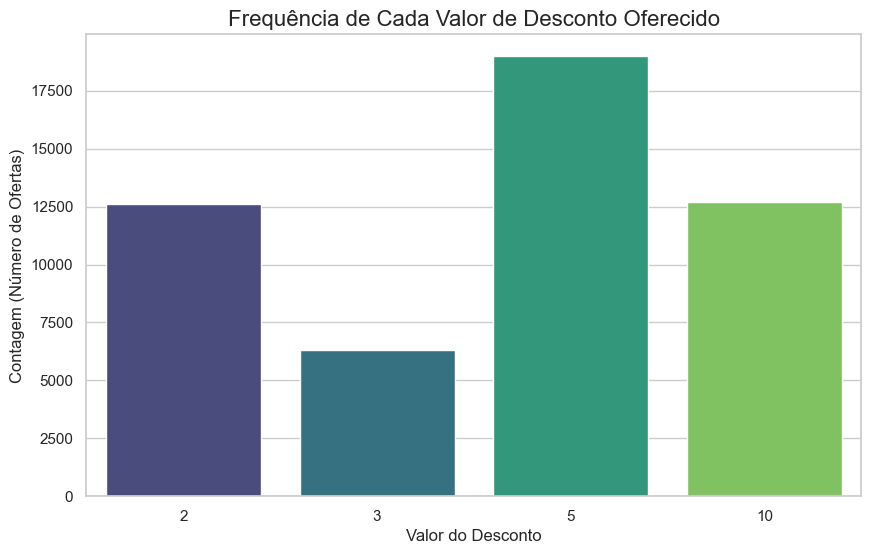

In [6]:
discount_counts_pd = offers_df.filter("discount_value > 0") \
                                .groupBy('discount_value') \
                                .count() \
                                .orderBy('count', ascending=False) \
                                .toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=discount_counts_pd, x='discount_value', y='count', palette='viridis')

plt.title('Frequência de Cada Valor de Desconto Oferecido', fontsize=16)
plt.xlabel('Valor do Desconto', fontsize=12)
plt.ylabel('Contagem (Número de Ofertas)', fontsize=12)
plt.show()

Maiores valores de desconto estão no valor de 5 reais, mas com range de 2 até 10 reais

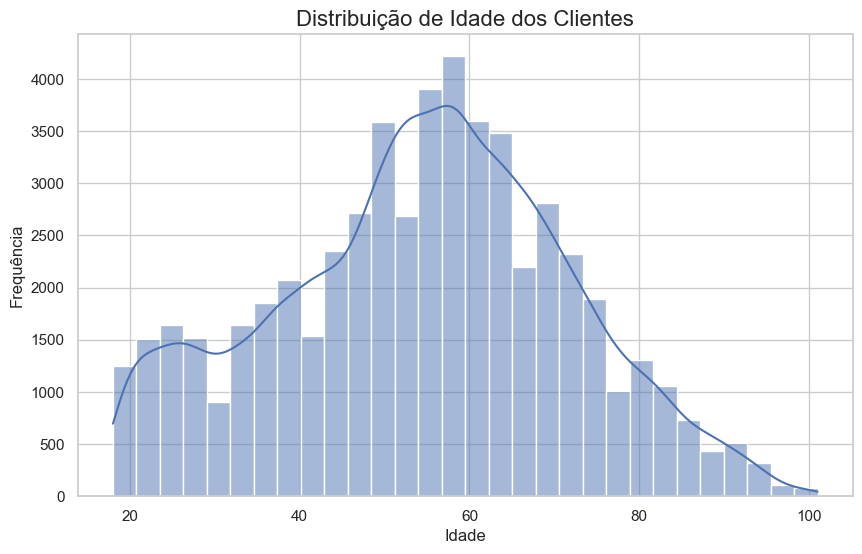

In [7]:
age_pd = offers_df.select('age').dropna().toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(data=age_pd, x='age', kde=True, bins=30)

plt.title('Distribuição de Idade dos Clientes', fontsize=16)
plt.xlabel('Idade', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.show()

Idades mais concentradas em clientes entre 60 anos, mas com clientes começando em 18 até 100+ (foram removidos os registros incorretos de "118 anos")

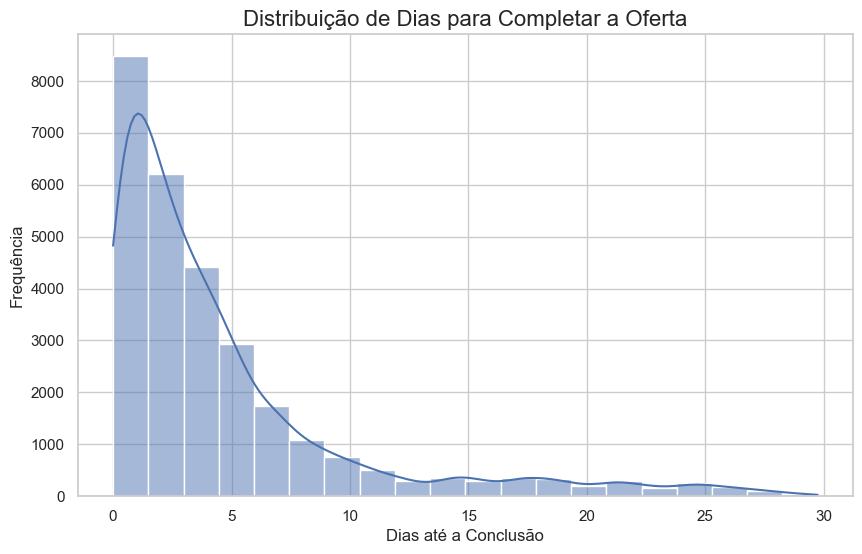

In [8]:
days_to_complete_pd = offers_df.select('days_to_complete_offer').dropna().toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(data=days_to_complete_pd, x='days_to_complete_offer', kde=True, bins=20)

plt.title('Distribuição de Dias para Completar a Oferta', fontsize=16)
plt.xlabel('Dias até a Conclusão', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.show()

A maioria dos clientes são convertidos logo nos 5 primeiros dias (dá para se observar um padrão de pareto 80% 20%)

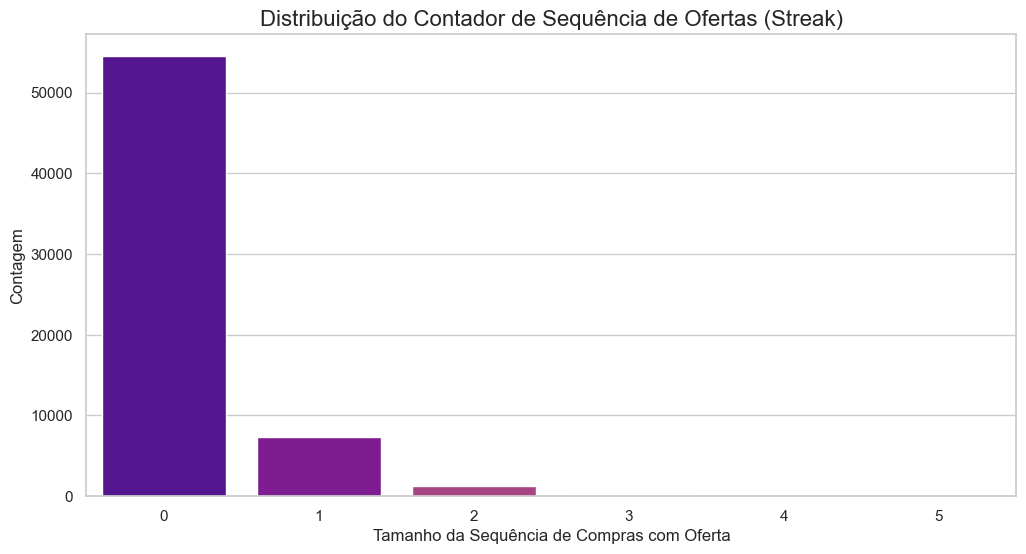

In [9]:
offer_streak_counts_pd = offers_df.groupBy('offer_streak_counter') \
                                  .count() \
                                  .orderBy('offer_streak_counter') \
                                  .toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=offer_streak_counts_pd, x='offer_streak_counter', y='count', palette='plasma')

plt.title('Distribuição do Contador de Sequência de Ofertas (Streak)', fontsize=16)
plt.xlabel('Tamanho da Sequência de Compras com Oferta', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.show()

A grande maioria dos usuários que utizam ofertas, utilizam uma oferta e na próxima fazem uma transação sem precisar de ofertas. Mostra certa fidelização dos clientes

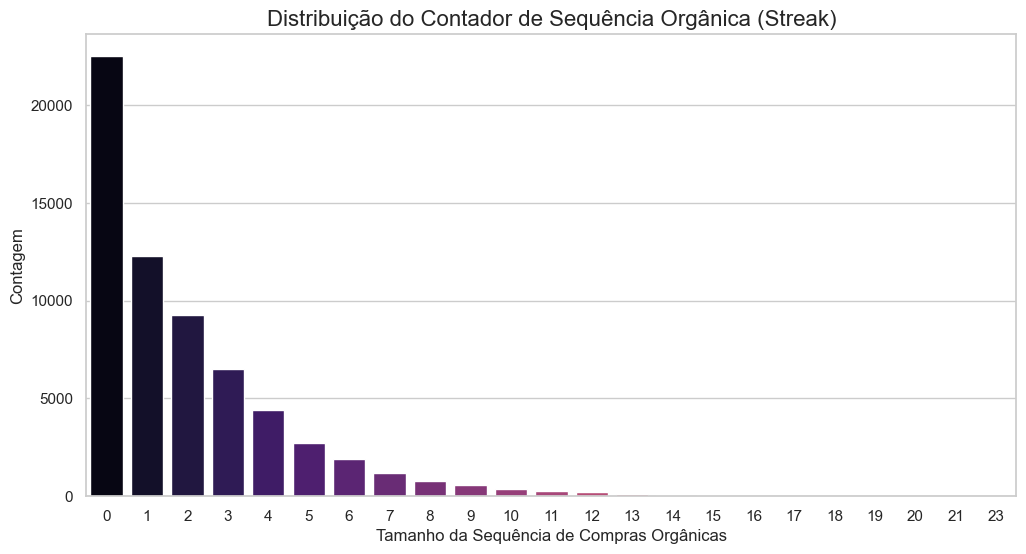

In [10]:
organic_streak_counts_pd = offers_df.groupBy('organic_streak_counter') \
                                    .count() \
                                    .orderBy('organic_streak_counter') \
                                    .toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=organic_streak_counts_pd, x='organic_streak_counter', y='count', palette='magma')

plt.title('Distribuição do Contador de Sequência Orgânica (Streak)', fontsize=16)
plt.xlabel('Tamanho da Sequência de Compras Orgânicas', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.show()

Visualmente bem ser aproxima bem com uma função 1/x. Interessante que os clientes ficam várias e várias transações comprando sem utilizar cupons

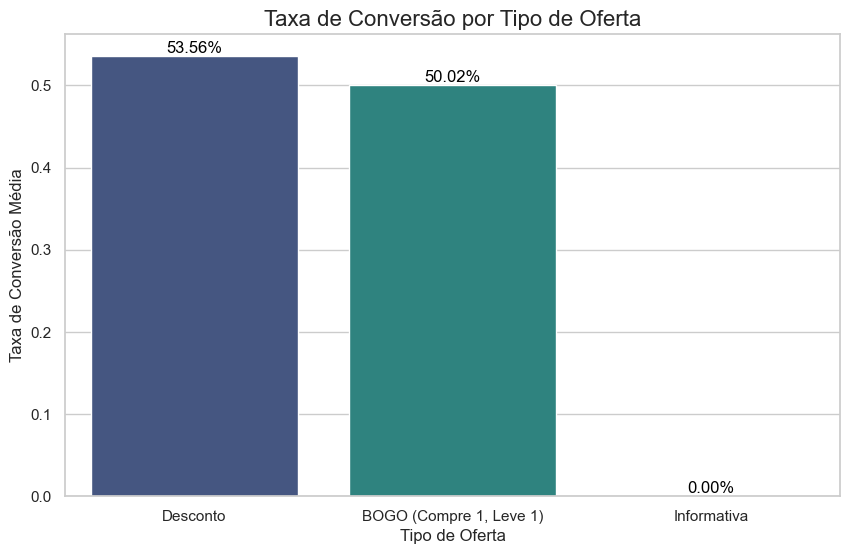

In [11]:
# 1. Em Spark: Crie uma coluna 'offer_type' a partir das colunas one-hot encoded
offers_with_type = offers_df.withColumn(
    'offer_type',
    F.when(F.col('offer_type_bogo') == 1, 'BOGO (Compre 1, Leve 1)')
     .when(F.col('offer_type_discount') == 1, 'Desconto')
     .otherwise('Informativa')
)

# 2. Em Spark: Agrupe por tipo de oferta e calcule a taxa de conversão (média de 'offer_generated_transaction')
conversion_by_type_pd = offers_with_type.groupBy('offer_type') \
                                        .agg(F.avg('offer_generated_transaction').alias('conversion_rate'),
                                             F.count('*').alias('total_offers')) \
                                        .orderBy('conversion_rate', ascending=False) \
                                        .toPandas()

# 3. Plotagem com Seaborn
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=conversion_by_type_pd, x='offer_type', y='conversion_rate', palette='viridis')

# Adiciona o valor da taxa de conversão no topo de cada barra
for index, row in conversion_by_type_pd.iterrows():
    barplot.text(index, row.conversion_rate, f'{row.conversion_rate:.2%}', color='black', ha="center", va='bottom')

plt.title('Taxa de Conversão por Tipo de Oferta', fontsize=16)
plt.xlabel('Tipo de Oferta', fontsize=12)
plt.ylabel('Taxa de Conversão Média', fontsize=12)
plt.show()

Informativos não geram transações, acredito que fazer uma inferência causal nessas duas flags faz muito sentido

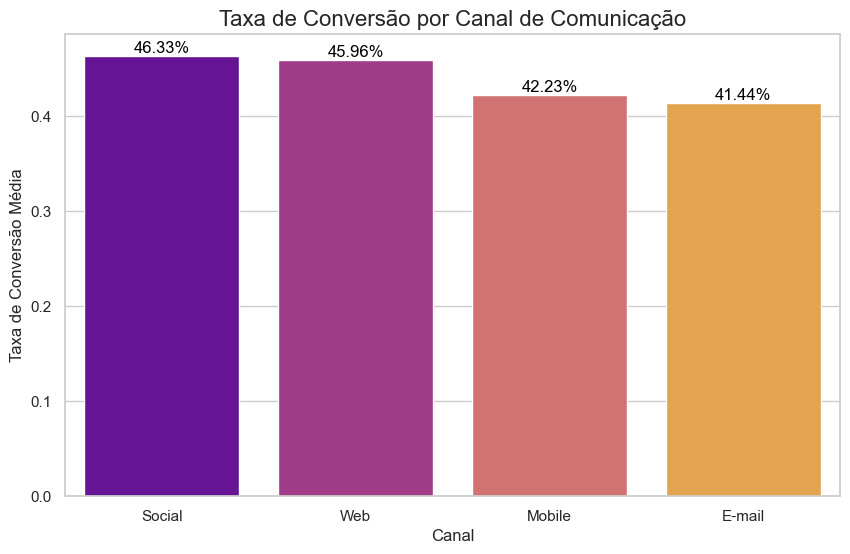

In [ ]:
channel_web_df = offers_df.filter(F.col('channel_web') == 1).withColumn('channel', F.lit('Web'))
channel_email_df = offers_df.filter(F.col('channel_email') == 1).withColumn('channel', F.lit('E-mail'))
channel_mobile_df = offers_df.filter(F.col('channel_mobile') == 1).withColumn('channel', F.lit('Mobile'))
channel_social_df = offers_df.filter(F.col('channel_social') == 1).withColumn('channel', F.lit('Social'))

unioned_channels_df = channel_web_df.unionByName(channel_email_df) \
                                    .unionByName(channel_mobile_df) \
                                    .unionByName(channel_social_df)

conversion_by_channel_pd = unioned_channels_df.groupBy('channel') \
                                                .agg(F.avg('offer_generated_transaction').alias('conversion_rate')) \
                                                .orderBy('conversion_rate', ascending=False) \
                                                .toPandas()

plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=conversion_by_channel_pd, x='channel', y='conversion_rate', palette='plasma')

for index, row in conversion_by_channel_pd.iterrows():
    barplot.text(index, row.conversion_rate, f'{row.conversion_rate:.2%}', color='black', ha="center", va='bottom')

plt.title('Taxa de Conversão por Canal de Comunicação', fontsize=16)
plt.xlabel('Canal', fontsize=12)
plt.ylabel('Taxa de Conversão Média', fontsize=12)
plt.show()

Ofertas Social e Web geram mais transações do que mobile/email

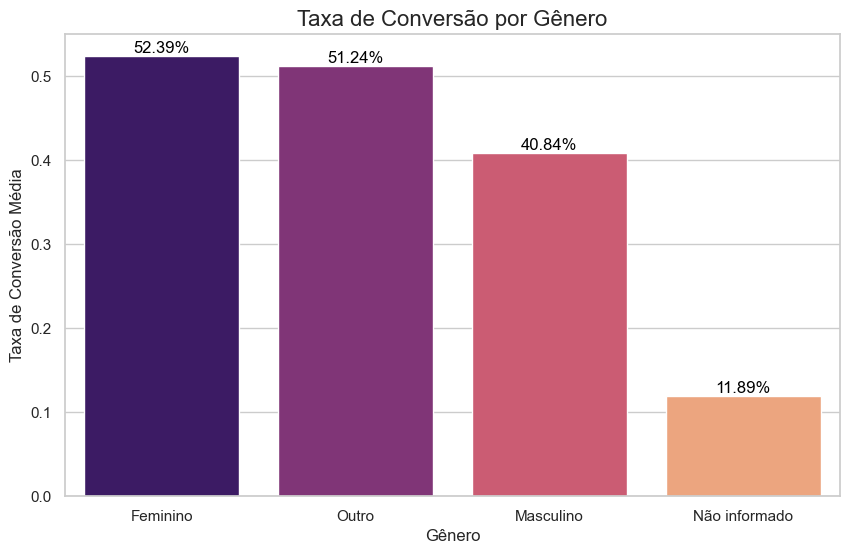

In [12]:
offers_with_gender = offers_df.withColumn(
    'gender',
    F.when(F.col('gender_F') == 1, 'Feminino')
     .when(F.col('gender_M') == 1, 'Masculino')
     .when(F.col('gender_O') == 1, 'Outro')
     .otherwise('Não informado')
)

conversion_by_gender_pd = offers_with_gender.groupBy('gender') \
                                             .agg(F.avg('offer_generated_transaction').alias('conversion_rate')) \
                                             .orderBy('conversion_rate', ascending=False) \
                                             .toPandas()

plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=conversion_by_gender_pd, x='gender', y='conversion_rate', palette='magma')

for index, row in conversion_by_gender_pd.iterrows():
    barplot.text(index, row.conversion_rate, f'{row.conversion_rate:.2%}', color='black', ha="center", va='bottom')

plt.title('Taxa de Conversão por Gênero', fontsize=16)
plt.xlabel('Gênero', fontsize=12)
plt.ylabel('Taxa de Conversão Média', fontsize=12)
plt.show()

Publico feminino gerando mais transações para essas ofertas, pode ser interessante em um próximo passo entender porque essas ofertas converetem tão bem nesse público

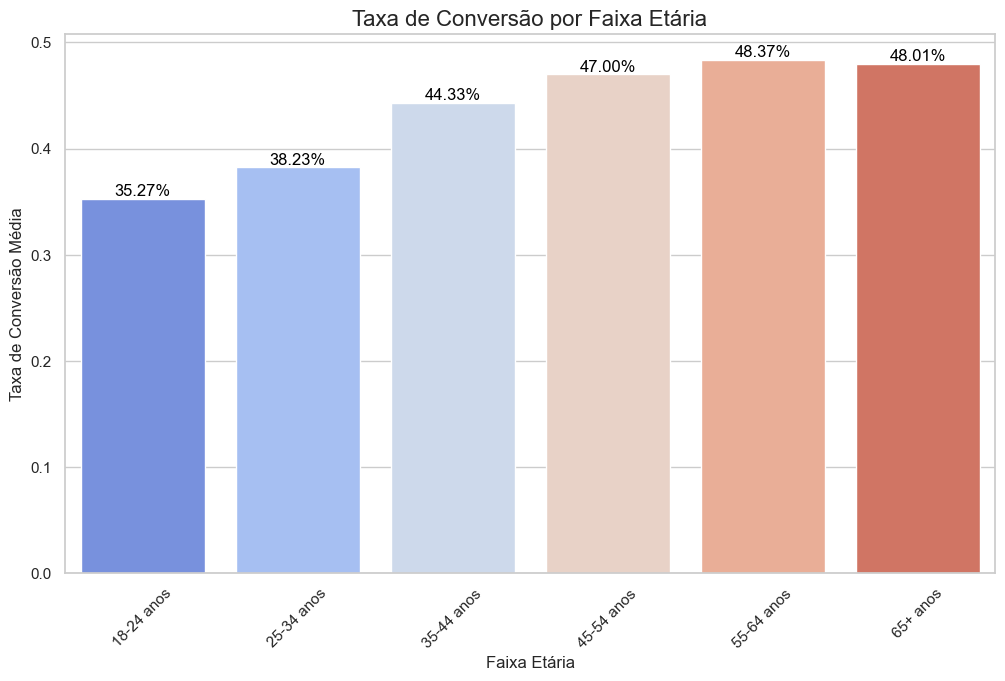

In [ ]:
offers_with_age_range = offers_df.filter(F.col('age').isNotNull()).withColumn(
    'age_range',
    F.when(F.col('age') < 18, 'Menos de 18')
     .when((F.col('age') >= 18) & (F.col('age') <= 24), '18-24 anos')
     .when((F.col('age') >= 25) & (F.col('age') <= 34), '25-34 anos')
     .when((F.col('age') >= 35) & (F.col('age') <= 44), '35-44 anos')
     .when((F.col('age') >= 45) & (F.col('age') <= 54), '45-54 anos')
     .when((F.col('age') >= 55) & (F.col('age') <= 64), '55-64 anos')
     .otherwise('65+ anos')
)

conversion_by_age_pd = offers_with_age_range.groupBy('age_range') \
                                            .agg(F.avg('offer_generated_transaction').alias('conversion_rate')) \
                                            .orderBy('age_range') \
                                            .toPandas()

plt.figure(figsize=(12, 7))
barplot = sns.barplot(data=conversion_by_age_pd, x='age_range', y='conversion_rate', palette='coolwarm')

for index, row in conversion_by_age_pd.iterrows():
    barplot.text(index, row.conversion_rate, f'{row.conversion_rate:.2%}', color='black', ha="center", va='bottom')

plt.title('Taxa de Conversão por Faixa Etária', fontsize=16)
plt.xlabel('Faixa Etária', fontsize=12)
plt.ylabel('Taxa de Conversão Média', fontsize=12)
plt.xticks(rotation=45) 
plt.show()

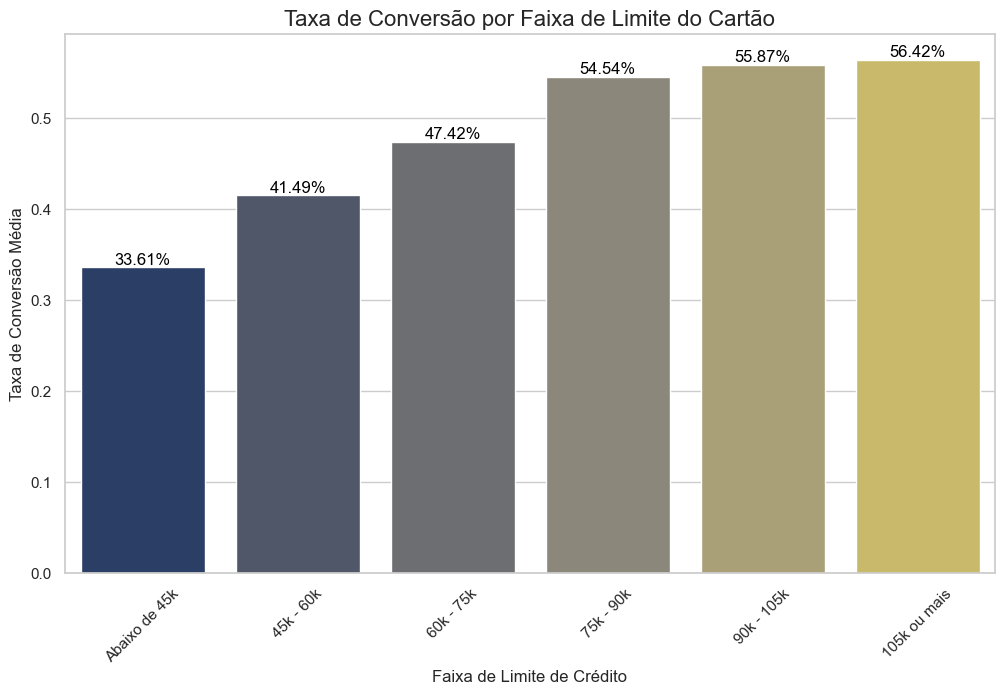

In [ ]:

offers_with_limit_range = offers_df.filter(F.col('credit_card_limit').isNotNull()).withColumn(
    'credit_limit_range',
    F.when(F.col('credit_card_limit') < 45000, 'Abaixo de 45k')
     .when((F.col('credit_card_limit') >= 45000) & (F.col('credit_card_limit') < 60000), '45k - 60k')
     .when((F.col('credit_card_limit') >= 60000) & (F.col('credit_card_limit') < 75000), '60k - 75k')
     .when((F.col('credit_card_limit') >= 75000) & (F.col('credit_card_limit') < 90000), '75k - 90k')
     .when((F.col('credit_card_limit') >= 90000) & (F.col('credit_card_limit') < 105000), '90k - 105k')
     .otherwise('105k ou mais')
)

conversion_by_limit_agg = offers_with_limit_range.groupBy('credit_limit_range') \
                                                 .agg(F.avg('offer_generated_transaction').alias('conversion_rate'))

collected_data = conversion_by_limit_agg.collect()

range_order = ['Abaixo de 45k', '45k - 60k', '60k - 75k', '75k - 90k', '90k - 105k', '105k ou mais']
data_map = {row['credit_limit_range']: row['conversion_rate'] for row in collected_data}

x_labels = range_order
y_values = [data_map.get(label, 0) for label in x_labels]

plt.figure(figsize=(12, 7))
barplot = sns.barplot(x=x_labels, y=y_values, palette='cividis')

for i, rate in enumerate(y_values):
    barplot.text(i, rate, f'{rate:.2%}', color='black', ha="center", va='bottom')

plt.title('Taxa de Conversão por Faixa de Limite do Cartão', fontsize=16)
plt.xlabel('Faixa de Limite de Crédito', fontsize=12)
plt.ylabel('Taxa de Conversão Média', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Mais limite do cartão = Maior taxa de ofertas gerando transações

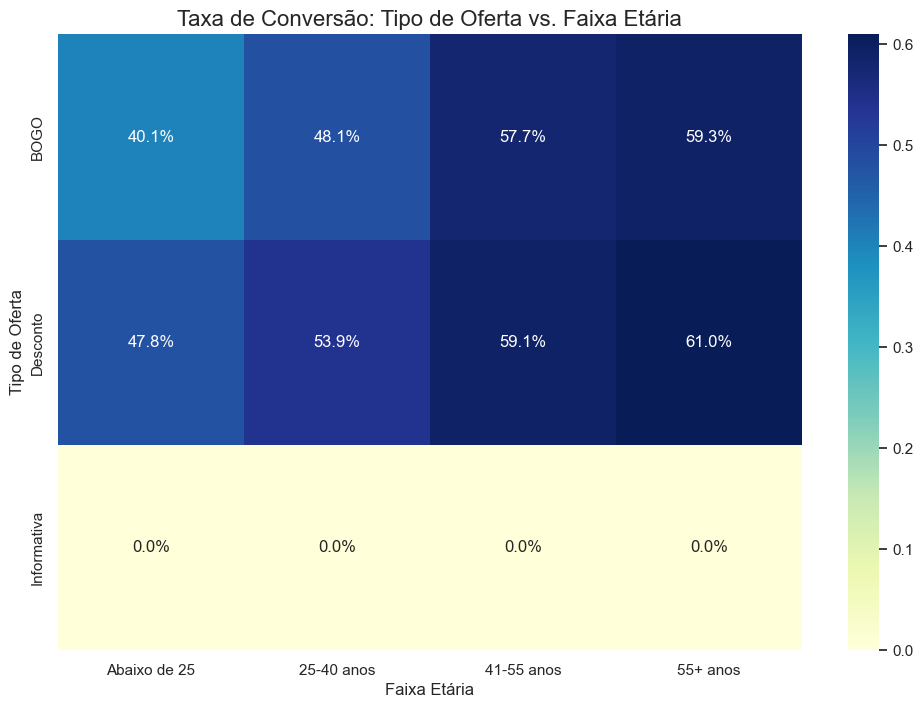

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F

# --- Preparação e Agregação no Spark ---

# 1. Cria as colunas 'offer_type' e 'age_range'
df_prepared = offers_df.filter(F.col('age').isNotNull()).withColumn(
    'offer_type',
    F.when(F.col('offer_type_bogo') == 1, 'BOGO')
     .when(F.col('offer_type_discount') == 1, 'Desconto')
     .otherwise('Informativa')
).withColumn(
    'age_range',
    F.when(F.col('age') < 25, 'Abaixo de 25')
     .when((F.col('age') >= 25) & (F.col('age') <= 40), '25-40 anos')
     .when((F.col('age') >= 41) & (F.col('age') <= 55), '41-55 anos')
     .otherwise('55+ anos')
)

# 2. Agrega os dados para calcular a taxa de conversão para cada combinação
conversion_agg = df_prepared.groupBy('offer_type', 'age_range') \
                            .agg(F.avg('offer_generated_transaction').alias('conversion_rate'))

# --- Coleta e Preparação para Plotagem (sem Pandas) ---

# 3. Coleta o resultado agregado para o driver
collected_data = conversion_agg.collect()

# 4. Pivota os dados manualmente para o formato de matriz (necessário para o heatmap)
age_labels = ['Abaixo de 25', '25-40 anos', '41-55 anos', '55+ anos']
offer_labels = ['BOGO', 'Desconto', 'Informativa']

# Cria um dicionário para busca rápida: { ('BOGO', '25-40 anos'): 0.75, ... }
data_map = {(row['offer_type'], row['age_range']): row['conversion_rate'] for row in collected_data}

# Cria a matriz de dados para o heatmap
heatmap_data = []
for offer in offer_labels:
    row_data = []
    for age in age_labels:
        rate = data_map.get((offer, age), 0) # Usa .get com default 0 se a combinação não existir
        row_data.append(rate)
    heatmap_data.append(row_data)

# --- Visualização ---

# 5. Plota o heatmap com Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, 
            annot=True,              # Anota os valores nas células
            fmt=".1%",               # Formata como porcentagem
            cmap='YlGnBu',           # Escolhe um mapa de cores
            xticklabels=age_labels, 
            yticklabels=offer_labels)

plt.title('Taxa de Conversão: Tipo de Oferta vs. Faixa Etária', fontsize=16)
plt.xlabel('Faixa Etária', fontsize=12)
plt.ylabel('Tipo de Oferta', fontsize=12)
plt.show()

Taxa de transações geradas por ofertas variam bastante conforme faixas etárias. Compre um leve 2 não funciona tão bem em públicos mais jovens